In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# using colab

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import copy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import pandas as pd

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

In [9]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = 'cuda'
else:
    device = 'cpu'
print('device: %s' %device)

device: cuda


In [10]:
with open('/content/drive/MyDrive/imb.pickle','rb') as handle:
    imb = pickle.load(handle)

In [11]:
# exploring data 
# 0~6 interval. -> standardize
std_x_subtrain = copy.deepcopy(imb['X_subtrain'])
std_x_valid = copy.deepcopy(imb['X_valid'])
std_x_test = copy.deepcopy(imb['X_test'])
for i in range(7):
    tmpstd = np.std(std_x_subtrain[:,i],ddof=1) # unbiased estimator
    tmpmean = np.mean(std_x_subtrain[:,i])
    std_x_subtrain[:,i] = (std_x_subtrain[:,i]-tmpmean)/tmpstd
for i in range(7):
    tmpstd = np.std(std_x_valid[:,i],ddof=1) # unbiased estimator
    tmpmean = np.mean(std_x_valid[:,i])
    std_x_valid[:,i] = (std_x_valid[:,i]-tmpmean)/tmpstd
for i in range(7):
    tmpstd = np.std(std_x_test[:,i],ddof=1) # unbiased estimator
    tmpmean = np.mean(std_x_test[:,i])
    std_x_test[:,i] = (std_x_test[:,i]-tmpmean)/tmpstd

In [12]:

X_subtrain_tensor = torch.tensor(std_x_subtrain, dtype=torch.float).to(device)
y_subtrain_tensor = torch.tensor(imb["y_subtrain"], dtype=torch.float).to(device)
X_valid_tensor = torch.tensor(std_x_valid, dtype=torch.float).to(device)
y_valid_tensor = torch.tensor(imb["y_valid"], dtype=torch.float).to(device)
X_test_tensor = torch.tensor(std_x_test, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(imb["y_test"], dtype=torch.float).to(device)

In [13]:
print(device)

cuda


In [14]:
class Dataset(data.Dataset):
    def __init__(self, Xnp, Ynp):
        'Initialization, passing Xnp and Ynp'
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
    def __len__(self):
        'Denotes the total number of samples'
        return self.nobs
    def __getitem__(self, index):
        'Generates one sample of data'        
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y

# DNN model

In [15]:
class DNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out, nb_h_layers, dropout = 0):
        super(DNN, self).__init__() 
        nn_list = []
        # hidden layer
        for i in range(nb_h_layers):
            if i == 0:
                nn_list.append(torch.nn.Linear(D_in, H))
            else:
                nn_list.append(torch.nn.Linear(H, H))
        # output layer
        nn_list.append(torch.nn.Linear(H, D_out))
        
        self.nb_layers = nb_h_layers + 1
        self.layer_list = torch.nn.ModuleList(nn_list)
        self.dropout = torch.nn.Dropout(dropout, inplace = True)
        
    def forward(self, x):
        # hidden layer
        for i in range(self.nb_layers - 1):
            x = F.relu(self.layer_list[i](x))
            self.dropout(x)
        # output layer
        x = self.layer_list[self.nb_layers - 1](x)
        return x

# Focal Loss 

In [16]:
# loss focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2,reduction="mean",devices="cuda"):
        super(FocalLoss, self).__init__()
        self.weight = torch.Tensor([alpha, 1-alpha]).to(devices)
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        log_prob = F.log_softmax(inputs, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob, 
            targets, 
            weight=self.weight,
            reduction = self.reduction
        )

In [17]:
subtrain_set = Dataset(X_subtrain_tensor,y_subtrain_tensor)
subtrainloader = data.DataLoader(subtrain_set,batch_size =10000,shuffle=True,num_workers = 0)

In [5]:
lr_rates = [1e-4,1e-3,1e-2,1e-1]
dropout_rates = [0.5] 
Hs = [90, 180, 360] 
nb_h_layers = [1,2,3,4]
alphas = [0.1,0.25,0.4] 
gammas = [2,3.5,5,7] 

In [6]:
def predicts(ou):
    return (ou[:, 0] < ou[:, 1]).type(torch.int)

## In reality, each members in our group is reponsible for a specific learning rate, since it will take too long to finish total 288 models in a computer. Colab session will stop before we can process all models.
## This cell is runnable, but i interrupt it . 

In [18]:

result_pd = pd.DataFrame()

# constant
max_epoch = 500
log_interval = 50
max_bacth_wait = 50

# tuning parameters

for H in Hs:
    for nb_h_layer in nb_h_layers:
        for a in alphas:
            for g in gammas:
                for lr_rate in lr_rates:
                    
                        
                    # variables
                    step_index = 0
                    batch_wait = 0
                    subtrain_FLs = []
                    valid_FLs = []
                    best_valid_FL = -1
                    best_state_dict = -1
                    # model optimizer loss
                    net = DNN(X_subtrain_tensor.shape[1], H, 2, nb_h_layer, dropout = 0.5).to(device)
                    optimizer = torch.optim.Adam(net.parameters(), lr = lr_rate)
                    loss_fn = FocalLoss(reduction="sum",alpha = a,gamma = g)     # focal loss
                    
                    for epoch in range(max_epoch):
                        for batch_index, (inputs, targets) in enumerate(subtrainloader):
                            inputs = inputs.to(device)
                            targets = targets.to(device)#.reshape(-1, 1)
                            step_index += 1
                            net.train()
                            optimizer.zero_grad()
                            outputs = net(inputs)

                            loss = loss_fn(outputs, targets.long())
                            #print(loss)
                            loss.backward()
                            optimizer.step()
                            
                            if step_index % log_interval == 0:
                                net.eval()
                                with torch.no_grad():
                                    outputs = net(X_subtrain_tensor)
                                    subtrain_FL = loss_fn(outputs, y_subtrain_tensor.long())

                                    # validation loss
                                    outputs = net(X_valid_tensor)
                                    op = predicts(outputs)
                                    y_valid = imb["y_valid"]
                                    f1 = f1_score(y_valid, op.cpu())
                                    valid_FL = loss_fn(outputs, y_valid_tensor.long())
                                    if valid_FL < best_valid_FL or best_valid_FL  == -1:
                                        best_valid_FL = valid_FL
                                        best_state_dict = net.state_dict().copy()
                                        batch_wait = 0
                                    else:
                                        batch_wait += 1
                                    
                                    subtrain_FLs.append(subtrain_FL)
                                    valid_FLs.append(valid_FL)
                                    print('Epoch = %d, step = %d, subtrain Focal loss = %f, valid Focal loss = %f, f1 = %f, batch_wait = %d'
                                          %(epoch, step_index, subtrain_FL, valid_FL, f1, batch_wait))
                            if batch_wait == max_bacth_wait:
                                break
                        if batch_wait == max_bacth_wait:
                            break
                    result_series = pd.Series({'lr_rate':lr_rate, 'H':H, 'dropout_rate': 0.5, 'nb_h_layers': nb_h_layer, 
                                            'best_valid_FL': best_valid_FL.item()})
                    result_pd = result_pd.append(result_series, ignore_index=True)
                    print('lr%f_H%d_a%0.1f_g%0.1f_hl%d best_valid FL: %f'%(lr_rate, H,a,g, nb_h_layer, best_valid_FL.item()))
                    net.load_state_dict(best_state_dict)
                    torch.save(net, '/content/drive/MyDrive/DNNModels/lr%f_H%d_d%0.1f_hl%d_a%0.2f_g%0.2f'%(lr_rate, H, 0.5, nb_h_layer, a, g))

Epoch = 2, step = 50, subtrain Focal loss = 5785.666504, valid Focal loss = 1933.515381, f1 = 0.162122, batch_wait = 0
Epoch = 4, step = 100, subtrain Focal loss = 5703.922363, valid Focal loss = 1907.503906, f1 = 0.187539, batch_wait = 0
Epoch = 7, step = 150, subtrain Focal loss = 5649.405762, valid Focal loss = 1890.755493, f1 = 0.210369, batch_wait = 0


KeyboardInterrupt: ignored

In [ ]:
# best model
dmodel = torch.load('/content/drive/MyDrive/DNNModels/lr0.000100_H180_d0.5_hl3_a0.10_g3.50')

In [ ]:
from sklearn.metrics import confusion_matrix
def specificity_score(y_true, y_predict):
    conf = confusion_matrix(y_true=y_true, y_pred=y_predict)
    return conf[0,0]/(conf[0,0]+conf[0, 1])

def opt_score(y_true, y_predict):
    target1_pro = 0.919271
    target0_pro = 1 - target1_pro
    
    opt_score = specificity_score(y_true, y_predict)*target1_pro*0.03 - (1-recall_score(y_true, y_predict))*target0_pro
    return (opt_score+0.1)*5
def opt_score2(y_true, y_predict, x_train):
    import numpy as np
    pos_index = (y_predict > 0.5).nonzero()
    neg_index = (y_predict < 0.5).nonzero()
    true_index = (y_true == 1).nonzero()
    false_index = (y_true == 0).nonzero()
    
    # specificity 
    s_index = np.intersect1d(neg_index, false_index)
    s_loss = x_train[s_index,3].sum() # annuty
    # (1-recall)
    invr_index = np.intersect1d(neg_index, true_index)
    invr_loss = x_train[invr_index, 2].sum() # credict
    
    return (s_loss - invr_loss)/x_train.shape[0]

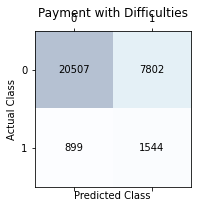

accuracy = 0.7170590530697191
f1_score = 0.26193909576724067
precision = 0.16520436550395892
recall = 0.6320098239869013
specificity = 0.7243986011515773
opt_score = 0.45135039937507443


In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

#net.load_state_dict(best_state_dict)
dmodel.eval()
output = dmodel(X_test_tensor).to("cpu")
result = predicts(output)
y_test = imb["y_test"]
plt_title = 'Payment with Difficulties'

from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test, y_pred=result)
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title(plt_title)
plt.tight_layout()
#plt.savefig('under_sampling_confusion_matrix.png', transparent = True)
plt.show()


acc = accuracy_score(y_test, result)
f1 = f1_score(y_test, result)
precision = precision_score(y_test, result)
recall = recall_score(y_test, result)
spe = specificity_score(y_test, result)
opt = opt_score(y_test, result)
print('accuracy =', acc)
print('f1_score =', f1)
print('precision =', precision)
print('recall =', recall)
print('specificity =', spe)
print('opt_score =', opt)
